# Outages and Storm EDA
Creator: [REDACTED]
This notebook is an EDA to understand the provided information and think about additional datasources to solve the problem.
The most relevant paper on OUTAGES can be seen [here](https://www.researchgate.net/publication/378737750_A_dataset_of_recorded_electricity_outages_by_United_States_county_2014-2022).

## Imports 

In [6]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import utils_dhm as ut

import src.utils as ut

## Configuration

In [2]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)

## Constants

In [10]:
# Eagle-I related data paths
YEAR = '2015'
EAGLEI_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/eaglei_data/'
MCC_PATH = f'{EAGLEI_DATA_PATH}MCC.csv'
DQI_PATH = f'{EAGLEI_DATA_PATH}DQI.csv'

# NOAA Storm Events related data paths
#NOAA_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/NOAA_StormEvents/'
#STORM_EVENTS_PATH = f'{NOAA_DATA_PATH}StormEvents_2014_2024.csv'
#STORM_DETAILS_PATH = f'{NOAA_DATA_PATH}StormEvents_details-ftp_v1.0_d2015_c20240716.csv'
NOAA_CLENADED_DATA_PATH = '../data/interim/storm_events_cleaned2.csv'

# Relevance is determined by the amount of customers being affected, in this case we define
CUSTOMERS_OUT_NB = ut.CUSTOMERS_OUT_NB

## Functions

In [7]:
def get_outages_index(outages_county):
    outages_county = outages_county.sort_values("run_start_time")
    # Then we keep only the relevant outage (affecting a high amount of customers)
    outages_county = outages_county[outages_county.customers_out >= CUSTOMERS_OUT_NB]
    # We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
    sepparation_hours = 18 # number of hours to define a sepparation between outages
    # We calculate the difference in seconds of each outage
    MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
    NB_15_MIN_IN_HOUR = 4
    outages_county['second_difference'] = outages_county.run_start_time.diff().dt.total_seconds()
    # Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
    sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR * (sepparation_hours)
    outages_county['interval_mark'] = (outages_county.second_difference.fillna(MIN_OUTAGE_SECONDS) >= sepparation_hours_seconds).astype(int)
    # then we do the cumulativesum to "generate an index" of same representation. 
    outages_county['outage_index'] = outages_county['interval_mark'].cumsum() 
    return outages_county

## Read data

### Power Outages:
We have a range of datasets, going from eaglei_outages_2014 to eaglei_outages_2023.
[EAGLE-I](https://eagle-i.doe.gov) is an interactive geographic information system (GIS) that allows users to view and map the nation's energy infrastructure and obtain near real-time informational updates concerning the electric, petroleum and natural gas sectors within one visualization platform.
It contains information on the total number of customers out of power for every 15 minutes that starts at `run_start_time`

The EAGLE-I outage data represents 80% to 90% of utility customers nationally, with higher coverage rates later in our dataset. The coverage extent increased as additional parsing capabilities were developed and as data sharing agreements with other response agencies and utilities were formalized. If an electric utility is not included in EAGLE-I monitoring, that utility is omitted from EAGLE-I data calculations. If a county has no covered electric customers because all utilities (one or more) associated with that county are not monitored by EAGLE-I, then that county is omitted from EAGLE-I reports and data calculations. In 2014, 1,072 counties had no outage data collected, while in 2022, only 182 counties had no outage data collected, out of 3,222 total counties and county equivalents.
This is according to [[1]](https://www.nature.com/articles/s41597-024-03095-5)

In [8]:
#outages = ut.get_required_outages_dfs(2014, 2015, 2016, eaglei_data_path=EAGLEI_DATA_PATH)
outages = ut.get_required_outages_dfs(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, eaglei_data_path=EAGLEI_DATA_PATH)

Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2014.csv.
Processing outages...
Deleting customers_out nulls...
Keeping relevant outages according to CUSTOMERS_OUT_NB=3162.2776601683795
Changing run_start_time to datetime...
Mapping state_ids...
Filling fips_code_ids...
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2015.csv.
Processing outages...
Deleting customers_out nulls...
Keeping relevant outages according to CUSTOMERS_OUT_NB=3162.2776601683795
Changing run_start_time to datetime...
Mapping state_ids...
Filling fips_code_ids...
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2016.csv.
Processing outages...
Deleting customers_out nulls...
Keeping relevant outages according to CUSTOMERS_OUT_NB=3162.2776601683795
Changing run_start_time to datetime...
Mapping state_ids...
Filling fips_code_ids...
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei

In [9]:
outages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1501540 entries, 54 to 26100923
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   fips_code       1501540 non-null  int64         
 1   county          1501540 non-null  object        
 2   state           1501540 non-null  object        
 3   customers_out   1501540 non-null  float64       
 4   run_start_time  1501540 non-null  datetime64[ns]
 5   state_id        1500040 non-null  object        
 6   fips_code_id    1501540 non-null  object        
 7   sub_general_id  1500040 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 103.1+ MB


In [6]:
outages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1501540 entries, 54 to 26100923
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   fips_code       1501540 non-null  int64         
 1   county          1501540 non-null  object        
 2   state           1501540 non-null  object        
 3   customers_out   1501540 non-null  float64       
 4   run_start_time  1501540 non-null  datetime64[ns]
 5   state_id        1500040 non-null  object        
 6   fips_code_id    1501540 non-null  object        
 7   sub_general_id  1500040 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 103.1+ MB


### Storm Data
Storm data is provided by the National Oceanic and Atmospheric Administration (NOAA). There is a recompilation of storm event details from 2014 to 2024, with one .csv file for each year. These files are directly downloaded from NOAA's storm events public database.

In [11]:
storm_events = pd.read_csv(NOAA_CLENADED_DATA_PATH)
#storm_details = pd.read_csv(STORM_DETAILS_PATH)

## Understand Data

### Outages

#### Outages Dataset

`fips_code`: _Federal Information Processing System (FIPS) Codes for States and Counties
FIPS codes are numbers which uniquely identify geographic areas.  The number of 
digits in FIPS codes vary depending on the level of geography.  State-level FIPS
codes have two digits, county-level FIPS codes have five digits of which the 
first two are the FIPS code of the state to which the county belongs._

`customers_out`: Amount of affected customers (estimate) at a 15-minute interval from the `run_start_time` moment. 

`state` and `county`: Deffinition of where the outage ocurred. 

`run_start_time`: Datetime of information on the customers_out measurement.

In [8]:
outages.sample(5)

,fips_code,county,state,customers_out,run_start_time,state_id,fips_code_id,sub_general_id
624114,6037,Los Angeles,California,3639.0,2020-01-10 20:00:00,CA,06037,06037_CA
3716771,6059,Orange,California,3825.0,2015-05-14 14:15:00,CA,06059,06059_CA
9885796,29189,St. Louis,Missouri,16123.0,2018-06-28 22:45:00,MO,29189,29189_MO
11566991,22017,Caddo,Louisiana,61676.0,2023-06-18 13:00:00,LA,22017,22017_LA
141903,23027,Waldo,Maine,3788.0,2014-11-05 10:45:00,ME,23027,23027_ME


In [9]:
# Small data process
#outages.run_start_time = pd.to_datetime(outages.run_start_time) # Transform into datetime to manipulate dates
#outages = outages[outages.customers_out.notna()] # Filter nan values from customers_out
#outages["state_id"] = outages.state.map(ut.STATE_ABBREVIATIONS) # Use the state abbreviations to get an ID
#outages["fips_code_id"] = outages.fips_code.astype(str).str.zfill(5)
#outages["sub_general_id"] = (outages.fips_code_id + '_' + outages.state_id)

In [10]:
#outages["general_id"] = (
#    outages.fips_code_id + '_' + 
#    outages.state_id + '_' + 
#    outages.run_start_time.dt.date.astype(str)

In [11]:
#outages.sample(5)

In [12]:
# 15-Minute intervals
#general_id_aggregation = outages.general_id.value_counts()

In [13]:
#plt.figure(figsize=(10,15))
#general_id_aggregation.rename("Time intervals").value_counts().sort_index().plot(kind='barh')
#plt.title("Count of the General_ids with different information dates")
# 96 is the maximum since it represents 24 hours * 4  15-minute intervals each hour
# 1 is the minimum since it represents only one register was captured. 

In [14]:
# 96 Registers over time (representing a day from the beginning 00:00 to the end 24:00)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==96
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [15]:
# 50 Registers over time (representing part of a day from the beginning (not necesarrily 00:00) to the end)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==50
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [16]:
# Sometimes there is no continuous outage information within a day. 
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==10
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

Small conclusion: Days are non-important we need to tackle the problem mesuring the span of the outage.

<Axes: xlabel='run_start_time', ylabel='customers_out'>

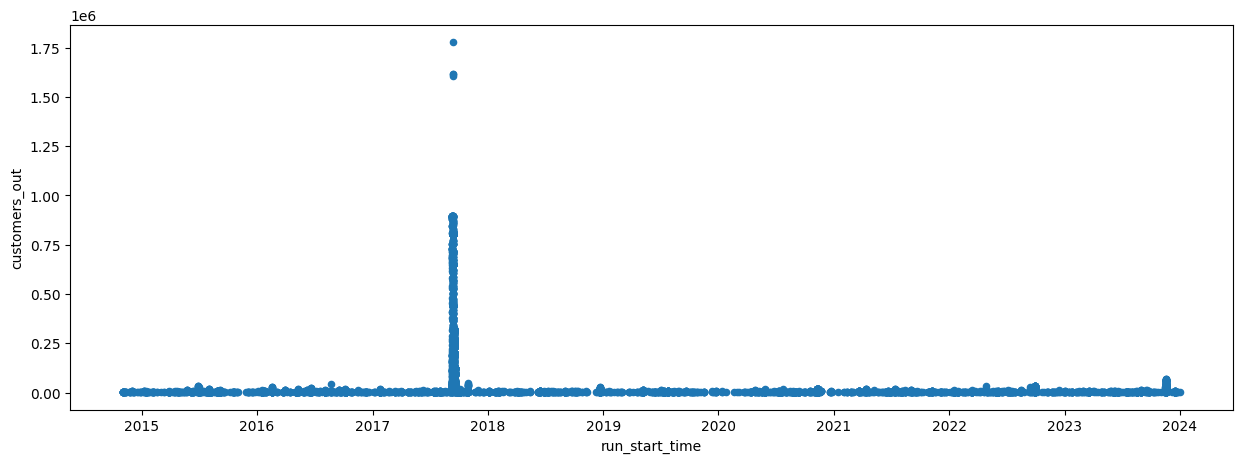

In [12]:
# In this initial test we grab a county
outage_test = outages[outages.sub_general_id=='12086_FL'].sort_values("run_start_time")
# Then we keep only the relevant outage (affecting a high amount of customers)
outage_test = outage_test[outage_test.customers_out >= CUSTOMERS_OUT_NB]

fig, ax = plt.subplots(figsize=(15,5))
outage_test.plot(x='run_start_time', y='customers_out', marker='o', ax=ax, kind='scatter')

<Axes: xlabel='run_start_time', ylabel='customers_out'>

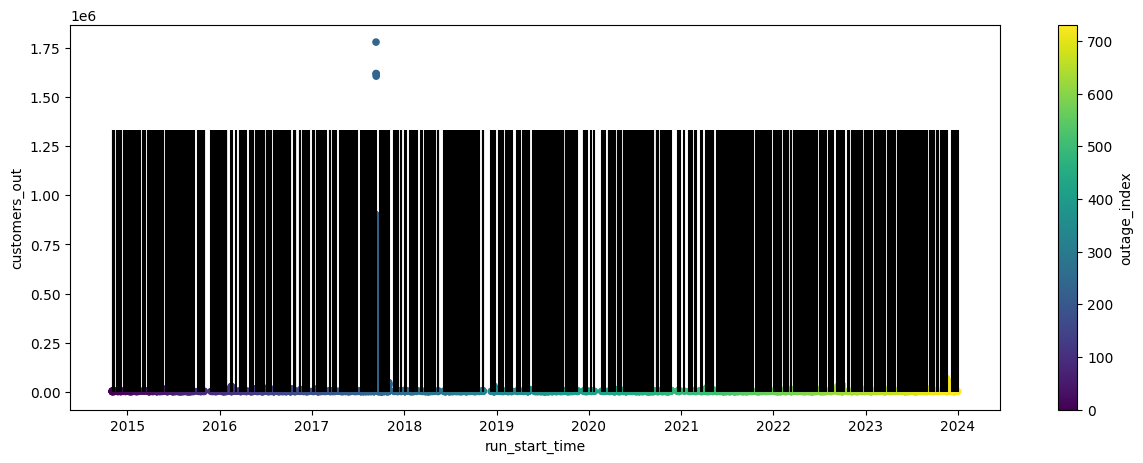

In [13]:
# We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
sepparation_hours = 18 # number of hours to define a sepparation between outages
# We calculate the difference in seconds of each outage
MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
NB_15_MIN_IN_HOUR = 4
outage_test['second_difference'] = outage_test.run_start_time.diff().dt.total_seconds()
# Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR *(sepparation_hours)
outage_test['interval_mark'] = (outage_test.second_difference.fillna(MIN_OUTAGE_SECONDS) >= sepparation_hours_seconds).astype(int)
# then we do the cumulativesum to "generate an index" of same representation. 
outage_test['outage_index'] = outage_test['interval_mark'].cumsum() 

# We can plot the "different outages", divided with the interval marks
fig, ax = plt.subplots(figsize=(15,5))
intervals = outage_test[outage_test['interval_mark']==1]
plt.vlines(intervals.run_start_time, 0, outage_test.customers_out.max()*0.75, color='k')
outage_test.plot(x='run_start_time', y='customers_out', c='outage_index', marker='o', ax=ax, kind='scatter',cmap='viridis')

In [14]:
pd.set_option('display.max_rows', 200)
outage_test

,fips_code,county,state,customers_out,run_start_time,state_id,fips_code_id,sub_general_id,second_difference,interval_mark,outage_index
45779,12086,Miami-Dade,Florida,4130.0,2014-11-02 11:45:00,FL,12086,12086_FL,NaN,0,0
46041,12086,Miami-Dade,Florida,4254.0,2014-11-02 12:00:00,FL,12086,12086_FL,900.0,0,0
46315,12086,Miami-Dade,Florida,4260.0,2014-11-02 12:15:00,FL,12086,12086_FL,900.0,0,0
48806,12086,Miami-Dade,Florida,3627.0,2014-11-02 14:00:00,FL,12086,12086_FL,6300.0,0,0
49264,12086,Miami-Dade,Florida,3806.0,2014-11-02 14:15:00,FL,12086,12086_FL,900.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
25463407,12086,Miami-Dade,Florida,3191.0,2023-12-20 13:45:00,FL,12086,12086_FL,900.0,0,727
25552413,12086,Miami-Dade,Florida,5146.0,2023-12-21 20:15:00,FL,12086,12086_FL,109800.0,1,728
25646704,12086,Miami-Dade,Florida,3907.0,2023-12-23 17:00:00,FL,12086,12086_FL,161100.0,1,729
25688462,12086,Miami-Dade,Florida,5286.0,2023-12-24 14:00:00,FL,12086,12086_FL,75600.0,1,730


In [15]:
#outage_test.outage_index.value_counts().sort_index().plot(kind="barh")

Text(0, 0.5, 'count')

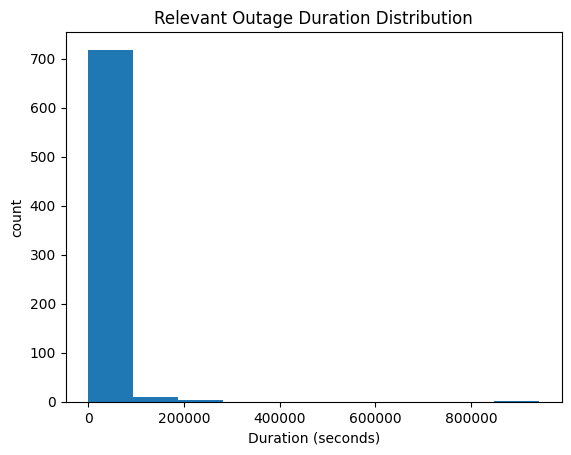

In [16]:
outage_test_summary = outage_test.groupby(
    'outage_index'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()
outage_test_summary['general_id'] = outage_test_summary.fips_code_id + '__' + outage_test_summary.outage_index.astype(str).str.zfill(4)
outage_test_summary['outage_duration'] = (
    outage_test_summary.run_start_time_max - outage_test_summary.run_start_time_min
).dt.total_seconds()

plt.title("Relevant Outage Duration Distribution")
plt.hist(outage_test_summary.outage_duration)
plt.xlabel('Duration (seconds)')
plt.ylabel('count')

In [17]:
# Do the same for all counties
outages_index = outages.groupby('sub_general_id').apply(get_outages_index)
outages_index['outage_index_id'] = outages_index.fips_code_id + '__' + outages_index.outage_index.astype(str).str.zfill(4)
outages_index_resumed = outages_index.groupby(
    'outage_index_id'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()

# We are adding the time interval of 15 miuntes to the last element. 
outages_index_resumed['run_start_time_max'] = outages_index_resumed['run_start_time_max'] + pd.to_timedelta(900, unit='s')

outages_index_resumed['outage_duration'] = (
    outages_index_resumed.run_start_time_max - outages_index_resumed.run_start_time_min
).dt.total_seconds()/3600/24 # We get the days of time difference

outages_index_resumed['outage_customers_over_duration'] = outages_index_resumed['total_customers_out']/outages_index_resumed['outage_duration']
outages_index_resumed['state'] = outages_index_resumed['state'].str.lower()

/tmp/ipykernel_11209/3235826873.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_index = outages.groupby('sub_general_id').apply(get_outages_index)


Text(0.5, 0, '(Duration) [days]')

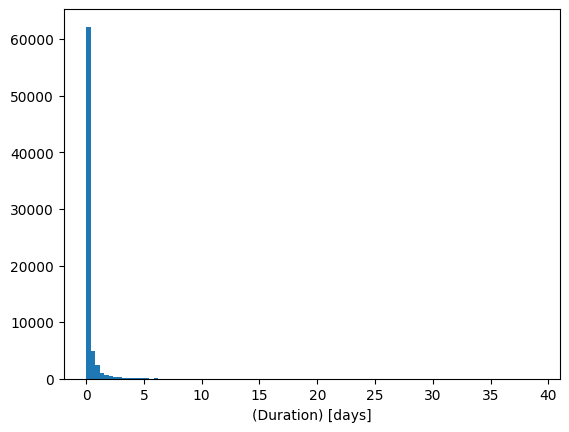

In [18]:
plt.hist(outages_index_resumed.outage_duration, bins=100,)
plt.xlabel('(Duration) [days]')

In [19]:
outages_index_resumed.sort_values("outage_duration", ascending=False).head()

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
3081,06007__0006,6007,06007,Butte,california,CA,3720,54894355.0,2018-11-08 17:15:00,2018-12-17 17:30:00,39.010417,1.407172e+06
72629,72113__0165,72113,72113,Ponce,puerto rico,PR,2956,241998070.0,2022-09-16 17:45:00,2022-10-22 18:30:00,36.031250,6.716338e+06
72289,72097__0171,72097,72097,Mayagüez,puerto rico,PR,2966,279741603.0,2022-09-17 12:30:00,2022-10-21 10:45:00,33.927083,8.245377e+06
27323,22019__0056,22019,22019,Calcasieu,louisiana,LA,2889,190747647.0,2020-08-27 03:30:00,2020-09-26 20:30:00,30.708333,6.211592e+06
27840,22051__0145,22051,22051,Jefferson,louisiana,LA,2470,182444623.0,2021-08-29 13:30:00,2021-09-26 23:15:00,28.406250,6.422693e+06


In [25]:
outages_index_resumed[outages_index_resumed.outage_duration==outages_index_resumed.outage_duration.max()]

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
3081,06007__0006,6007,06007,Butte,california,CA,3720,54894355.0,2018-11-08 17:15:00,2018-12-17 17:30:00,39.010417,1.407172e+06


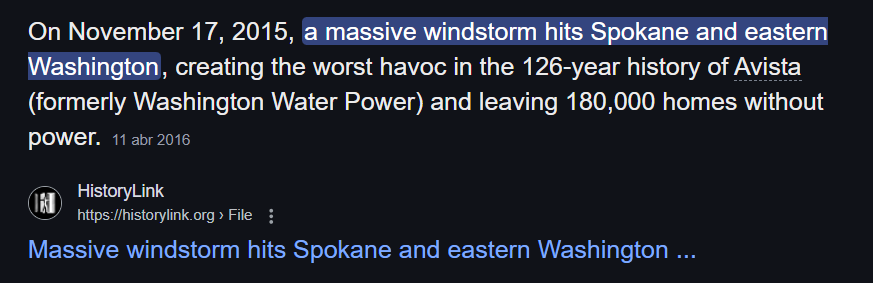

### Storms

#### Storm Events

In [20]:
#storm_events.columns, len(storm_events.columns)
storm_events.sample(5)

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,fips,fips__cz_name,new_fips
291701,291701,201806,18,2039,201806,18,2039,125435,752335,COLORADO,8,2018,June,Hail,C,87,MORGAN,BOU,18-JUN-18 20:39:00,MST-7,18-JUN-18 20:39:00,0,0,0,0,0.00K,0.00K,Trained Spotter,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NW,SNYDER,3.0,NW,SNYDER,40.3500,-103.6200,40.3500,-103.6200,The storms that moved across northern Washingt...,Large hail broke several windows.,CSV,8087,08087MORGAN,8087
207033,207033,201705,11,1717,201705,11,1717,114533,687116,TEXAS,48,2017,May,Thunderstorm Wind,C,459,UPSHUR,SHV,11-MAY-17 17:17:00,CST-6,11-MAY-17 17:17:00,0,0,0,0,0.00K,0.00K,NWS Storm Survey,61.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,WSW,UNION GROVE,2.0,WSW,UNION GROVE,32.5610,-94.9574,32.5610,-94.9574,Showers and thunderstorms developed over Eastc...,Large branches were blown down across a drivew...,CSV,48459,48459UPSHUR,48459
541116,541116,202205,24,1626,202205,24,1626,168273,1018735,TEXAS,48,2022,May,Thunderstorm Wind,C,219,HOCKLEY,LUB,24-MAY-22 16:26:00,CST-6,24-MAY-22 16:26:00,0,0,0,0,0.00K,0.00K,Mariner,56.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,S,LEVELLAND,4.0,S,LEVELLAND,33.5221,-102.3700,33.5221,-102.3700,Following severe weather the previous afternoo...,A Texas Tech University West Texas mesonet sit...,CSV,48219,48219HOCKLEY,48219
560394,560394,202304,22,1345,202304,22,1345,177981,1082373,PENNSYLVANIA,42,2023,April,Thunderstorm Wind,C,43,DAUPHIN,CTP,22-APR-23 13:45:00,EST-5,22-APR-23 13:45:00,0,0,0,0,6.00K,0.00K,Emergency Manager,52.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SW,OLMSTED AFB,0.0,SW,OLMSTED AFB,40.1983,-76.7528,40.1983,-76.7528,A cold front crossed Pennsylvania during the a...,A severe thunderstorm producing winds estimate...,CSV,42043,42043DAUPHIN,42043
581097,581097,202307,21,1325,202307,21,1425,182016,1118124,MASSACHUSETTS,25,2023,July,Flash Flood,C,11,FRANKLIN,BOX,21-JUL-23 13:25:00,EST-5,21-JUL-23 14:25:00,0,0,0,0,0.00K,0.00K,Fire Department/Rescue,NaN,NaN,Heavy Rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,SW,BURKVILLE,1.0,SW,BURKVILLE,42.5096,-72.7114,42.5094,-72.7115,A warm front stalled across Connecticut and Rh...,"In Conway, the South River was overflowing its...",CSV,25011,25011FRANKLIN,25011


In [21]:
# Lets consider only County
#storm_events = storm_events#[storm_events.CZ_TYPE == 'C']

In [22]:
storm_events.EVENT_TYPE.value_counts()

EVENT_TYPE
Thunderstorm Wind             186450
Hail                           97652
Flash Flood                    43539
Winter Weather                 40154
High Wind                      38746
Drought                        32432
Winter Storm                   31878
Flood                          30209
Marine Thunderstorm Wind       25147
Heavy Snow                     24231
Tornado                        15641
Heat                           15437
Heavy Rain                     15310
Excessive Heat                 13803
Strong Wind                    11356
Extreme Cold/Wind Chill         9511
Dense Fog                       7567
Cold/Wind Chill                 6306
Frost/Freeze                    6100
Blizzard                        5889
High Surf                       4329
Wildfire                        3637
Lightning                       3609
Tropical Storm                  3184
Funnel Cloud                    3071
Ice Storm                       2566
Coastal Flood              

In [28]:
storm_events.EVENT_TYPE.value_counts()

EVENT_TYPE
Thunderstorm Wind             186450
Hail                           97652
Flash Flood                    43539
Winter Weather                 40154
High Wind                      38746
Drought                        32432
Winter Storm                   31878
Flood                          30209
Marine Thunderstorm Wind       25147
Heavy Snow                     24231
Tornado                        15641
Heat                           15437
Heavy Rain                     15310
Excessive Heat                 13803
Strong Wind                    11356
Extreme Cold/Wind Chill         9511
Dense Fog                       7567
Cold/Wind Chill                 6306
Frost/Freeze                    6100
Blizzard                        5889
High Surf                       4329
Wildfire                        3637
Lightning                       3609
Tropical Storm                  3184
Funnel Cloud                    3071
Ice Storm                       2566
Coastal Flood              

In [23]:
begin_datetime = (
    storm_events['BEGIN_YEARMONTH'].astype(str) + 
    storm_events['BEGIN_DAY'].astype(str).str.zfill(2) + 
    storm_events['BEGIN_TIME'].astype(str).str.zfill(4)
)

end_datetime = (
    storm_events['END_YEARMONTH'].astype(str) + 
    storm_events['END_DAY'].astype(str).str.zfill(2) + 
    storm_events['END_TIME'].astype(str).str.zfill(4)
)

storm_events['BEGIN_DATETIME'] = pd.to_datetime(begin_datetime,format='%Y%m%d%H%M')
storm_events['END_DATETIME'] = pd.to_datetime(end_datetime, format='%Y%m%d%H%M')
storm_events['DURATION_HOURS'] = (
    storm_events['END_DATETIME'] - storm_events['BEGIN_DATETIME']
).dt.total_seconds() / 3600

storm_events['fips_code_id'] = storm_events.new_fips.astype(str).str.zfill(5)

In [24]:
#storm_events.EPISODE_ID.value_counts().head(30)

`EPISODE_ID`: ID assigned by NWS to denote the storm episode; links the event details file with the
information within location file

`EVENT_ID`: Primary database key field.ID assigned by NWS to note a single, small part that goes into a specific storm episode; links the storm episode between the three files downloaded from SPC’s website. 

`STATE`: The state name where the event occurred

`STATE_FIPS`:A unique number (State Federal Information Processing Standard) is assigned to the county by the National Institute for Standards and Technology (NIST)

`CZ_TYPE`: Indicates whether the event happened in a (C) county/parish, (Z) zone or (M) marine.

`CZ_FIPS`: The county FIPS number is a unique number assigned to the county by the National Institute for Standards and Technology (NIST) or NWS Forecast Zone Number.

`CZ_NAME`:County/Parish, Zone or Marine Name assigned to the county FIPS number or NWS Forecast Zone.

`WFO`: National Weather Service Forecast Office’s area of responsibility (County Warning Area) in which the event occurred

`BEGIN_DATE_TIME`: Date and time that storm event began (MM/DD/YYYY 24 hour time AM/PM).

`CZ_TIMEZONE`:(Time Zone for the County/Parish, Zone or Marine Name) Eastern Standard Time (EST), Central Standard Time (CST), Mountain Standard Time (MST), etc.

`END_DATE_TIME`: Date and time that storm event ended (MM/DD/YYYY 24 hour time AM/PM).

For more information visit this [link](https://adata.site.wesleyan.edu/files/2017/08/Storm_Event_Data_Codebook.pdf).


In [25]:
#storm_events_test

In [26]:
drop_cols = [
    'BEGIN_YEARMONTH',
    'BEGIN_DAY',
    'BEGIN_TIME',
    'END_YEARMONTH',
    'END_DAY',
    'END_TIME',
    'MONTH_NAME',
    'YEAR',
    'WFO',
    'BEGIN_DATE_TIME',
    'END_DATE_TIME',
    'INJURIES_DIRECT',
    'INJURIES_INDIRECT',
    'DEATHS_DIRECT',
    'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY',
    'DAMAGE_CROPS',
    'SOURCE',
    'MAGNITUDE',
    'MAGNITUDE_TYPE',
    'FLOOD_CAUSE',
    'CATEGORY',
    'TOR_F_SCALE',
    'TOR_LENGTH',
    'TOR_WIDTH',
    'TOR_OTHER_WFO',
    'TOR_OTHER_CZ_STATE',
    'TOR_OTHER_CZ_FIPS',
    'TOR_OTHER_CZ_NAME',
    'DATA_SOURCE'
]


/tmp/ipykernel_11209/570834128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_events_test.drop(columns=drop_cols, inplace=True)


Text(0.5, 0, 'Time')

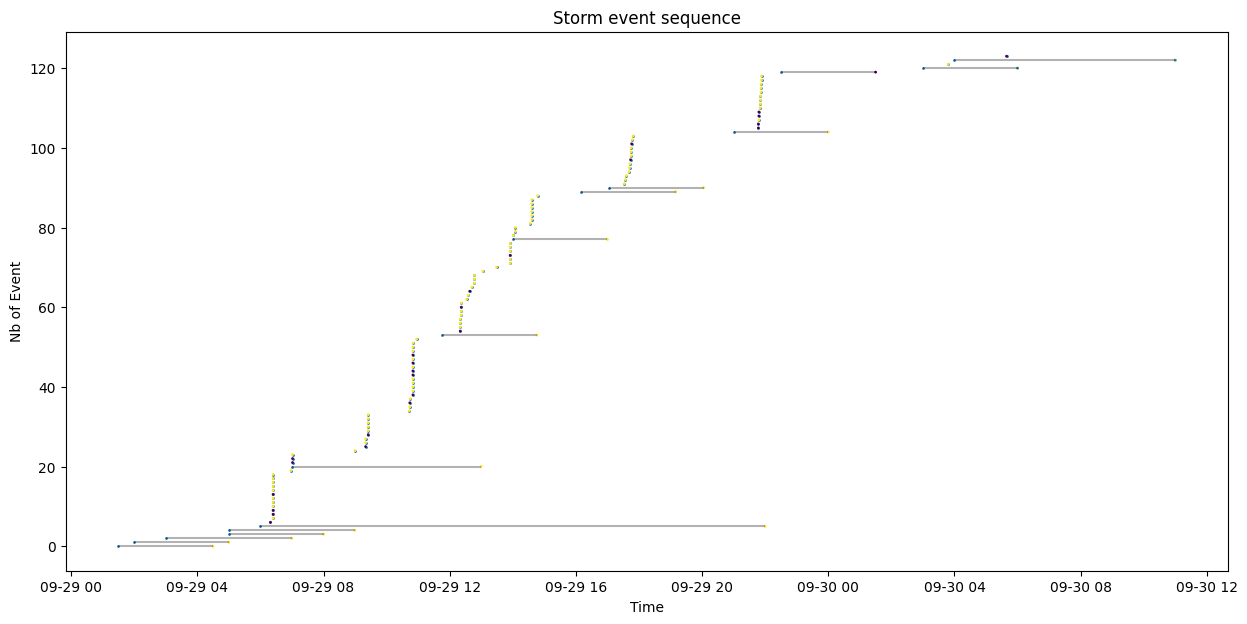

In [27]:
# Lets grab a sample
storm_events_test = storm_events[storm_events.EPISODE_ID==109423]
storm_events_test.drop(columns=drop_cols, inplace=True)
storm_events_test = storm_events_test.sort_values('BEGIN_DATETIME')#[storm_events_test.CZ_TYPE == 'C'].sort_values('BEGIN_DATETIME')
storm_events_test['sequence'] = range(storm_events_test.shape[0])

plt.figure(figsize=(15,7))
plt.scatter(storm_events_test.BEGIN_DATETIME, storm_events_test.sequence, s=1)
plt.scatter(storm_events_test.END_DATETIME, storm_events_test.sequence, s=1, c=storm_events_test.CZ_FIPS)
plt.hlines(storm_events_test.sequence, storm_events_test.BEGIN_DATETIME, storm_events_test.END_DATETIME, color='k', alpha=0.3)
plt.title('Storm event sequence')
plt.ylabel('Nb of Event')
plt.xlabel('Time')

In [28]:
storm_events.sample(1)

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,fips,fips__cz_name,new_fips,BEGIN_DATETIME,END_DATETIME,DURATION_HOURS,fips_code_id
8962,8962,201410,13,1405,201410,13,1405,89727,540811,MISSISSIPPI,28,2014,October,Thunderstorm Wind,C,15,CARROLL,JAN,13-OCT-14 14:05:00,CST-6,13-OCT-14 14:05:00,0,0,0,0,0.00K,0.00K,Law Enforcement,50.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,SE,SOMMERVILLE COMMUNIT,3.0,SE,SOMMERVILLE COMMUNIT,33.37,-89.8,33.37,-89.8,"A potent storm system, for mid October standar...",A few trees were down along Highway 35.,CSV,28015,28015CARROLL,28015,2014-10-13 14:05:00,2014-10-13 14:05:00,0.0,28015


In [29]:
# storm_events_grouped_fips = storm_events.sort_values(
#     'BEGIN_DATETIME'
# ).groupby(
#     ["EPISODE_ID", "fips_code_id"]
# ).agg(
#     nb_events=('EVENT_ID', 'count'),
#     affected_states=('STATE', 'first'),
#     affected_states_ids=('STATE_FIPS', 'first'),
#     distinct_events=('EVENT_TYPE', 'unique'),
#     touched_cz_names=('CZ_NAME', 'first'),
#     timezone=('CZ_TIMEZONE', 'first'),
#     episode_description=('EPISODE_NARRATIVE','first'),
#     begin_datetime=('BEGIN_DATETIME', 'min'),
#     end_datetime=('END_DATETIME', 'max'),
#     episode_narratives=('EPISODE_NARRATIVE', lambda x: list(x))
# ).reset_index()

# storm_events_grouped_fips['duration'] = ((storm_events_grouped_fips.end_datetime - storm_events_grouped_fips.begin_datetime).dt.total_seconds()/3600).replace(0, 0.01)
# storm_events_grouped_fips['state'] = storm_events_grouped_fips.affected_states.str.lower()

# storm_events_grouped_fips_with_outages = storm_events_grouped_fips.merge(
#     outages_index_resumed, 
#     on='fips_code_id', 
#     how='left',
# )

In [30]:
storm_episodes = storm_events.groupby(
    "EPISODE_ID"
).agg(
    nb_events=('EVENT_ID', 'count'),
    affected_states=('STATE', 'unique'),
    affected_states_ids=('STATE_FIPS', 'unique'),
    distinct_events=('EVENT_TYPE', 'unique'),
    fips_only_county_code_id=('CZ_FIPS', 'unique'),
    fips_code_id=('fips_code_id', 'unique'),
    touched_cz_names=('CZ_NAME', 'unique'),
    timezone=('CZ_TIMEZONE', 'unique'),
    episode_description=('EPISODE_NARRATIVE','first'),
    begin_datetime=('BEGIN_DATETIME', 'min'),
    end_datetime=('END_DATETIME', 'max'),
).reset_index()

storm_episodes['storm_duration'] = ((storm_episodes.end_datetime - storm_episodes.begin_datetime).dt.total_seconds()/3600).replace(0, 0.01)
storm_episodes['state'] = storm_episodes.affected_states.apply(lambda x: x[0]).str.lower()

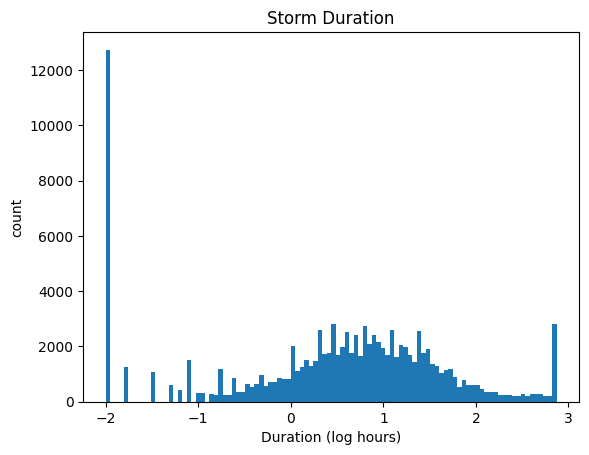

In [31]:
plt.title('Storm Duration')
plt.hist(np.log10(storm_episodes.storm_duration), bins=100)
plt.xlabel('Duration (log hours)')
plt.ylabel('count')
plt.show()

In [38]:
# This could be the minimum granularity level, which is storm episode, 
# however, we need to cross with the outages and see which counties were actually affected. 
storm_episodes.shape

(106934, 14)

In [32]:
# This could be the minimum granularity level, which is storm episode, 
# however, we need to cross with the outages and see which counties were actually affected. 
storm_episodes.shape

(106934, 14)

In [33]:
storm_episodes.sample(5)

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,fips_only_county_code_id,fips_code_id,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,storm_duration,state
16394,99099,2,[ATLANTIC SOUTH],[87],[Marine Thunderstorm Wind],[650],[87650],[Jupiter Inlet to Deerfield Beach FL out 20nm],[EST-5],A weak upper level trough of low pressure over...,2015-07-31 15:29:00,2015-07-31 15:45:00,0.266667,atlantic south
56582,142404,4,[OKLAHOMA],[40],[Thunderstorm Wind],[89],[40089],[MCCURTAIN],[CST-6],A longwave trough dug south into the Southern ...,2019-10-20 22:02:00,2019-10-21 00:55:00,2.883333,oklahoma
28617,112299,1,[LOUISIANA],[22],[Flash Flood],[33],[22121],[EAST BATON ROUGE],[CST-6],A stationary front provided a focus for the de...,2017-01-19 09:20:00,2017-01-19 13:30:00,4.166667,louisiana
53616,139200,4,[ALABAMA],[1],[Thunderstorm Wind],"[103, 49]","[01103, 01049]","[MORGAN, DEKALB]",[CST-6],Isolated thunderstorms developed during the ea...,2019-08-19 12:29:00,2019-08-19 16:55:00,4.433333,alabama
81,80643,24,[INDIANA],[18],[Winter Storm],"[9, 32, 24, 17, 16, 27, 26, 25, 8, 6, 7, 20, 2...","[18009, 18053, 18169, 18183, 18085, 18001, 181...","[DE KALB, GRANT, WABASH, WHITLEY, KOSCIUSKO, A...","[EST-5, CST-6]",A deepening low pressure system tracking north...,2014-01-04 18:00:00,2014-01-06 05:00:00,35.000000,indiana


In [34]:
storms_state_exploded = storm_episodes.explode('fips_code_id')
storms_state_exploded['episode_fips_id'] = (
    storms_state_exploded.EPISODE_ID.astype(str) 
    + '_' 
    + storms_state_exploded.fips_code_id.astype(str).str.zfill(5)
)
storm_state_exploded_columns = [
    'EPISODE_ID',
    'fips_code_id',
    'episode_description',
    'begin_datetime',
    'end_datetime', 
    'storm_duration',
    'episode_fips_id'
]
storms_state_exploded = storms_state_exploded[storm_state_exploded_columns]
# This might be the minimum granulairity level, which is storms in counties, because the outages are at a 
# "county" granularity, a storm can have different meteorological instances in different counties and therefore 
# different impact. 
storms_state_exploded.sample(5)

,EPISODE_ID,fips_code_id,episode_description,begin_datetime,end_datetime,storm_duration,episode_fips_id
42880,127578,19091,A frontal boundary was draped across areas jus...,2018-06-30 12:38:00,2018-06-30 23:59:00,11.350000,127578_19091
49193,134386,55057,A winter storm moved across the Upper Midwest ...,2019-02-11 16:00:00,2019-02-13 03:30:00,35.500000,134386_55057
26648,110150,28075,Dry conditions continued into October which re...,2016-10-11 06:00:00,2016-10-31 23:59:00,497.983333,110150_28075
92147,180669,47189,Scattered showers and thunderstorms developed ...,2023-07-13 19:21:00,2023-07-14 01:00:00,5.650000,180669_47189
87245,175359,06039,A strong low pressure system moved through cen...,2023-01-08 22:00:00,2023-01-11 16:11:00,66.183333,175359_06039


### Outages and Storms

In [35]:
len(set(outages_index_resumed.fips_code_id.value_counts().index)-set(storms_state_exploded.fips_code_id.value_counts().index))

36

In [41]:
len(set(outages_index_resumed.fips_code_id.value_counts().index)-set(storms_state_exploded.fips_code_id.value_counts().index))

39

In [36]:
len(set(storms_state_exploded.fips_code_id.value_counts().index) - set(outages_index_resumed.fips_code_id.value_counts().index))

1838

In [42]:
len(set(storms_state_exploded.fips_code_id.value_counts().index) - set(outages_index_resumed.fips_code_id.value_counts().index))

1834

In [37]:
storms_state_exploded.episode_fips_id.value_counts()

episode_fips_id
197269_12035    1
80464_39127     1
80465_54045     1
80465_54005     1
80465_54001     1
               ..
80470_54055     1
80469_37193     1
80469_37009     1
80469_37189     1
80468_51035     1
Name: count, Length: 412190, dtype: int64

In [43]:
storms_state_exploded.episode_fips_id.value_counts()

episode_fips_id
197269_12035    1
80464_39127     1
80465_54045     1
80465_54005     1
80465_54001     1
               ..
80469_37189     1
80468_51035     1
80468_51017     1
80468_51185     1
80468_51121     1
Name: count, Length: 412459, dtype: int64

In [38]:
storms_outages = storms_state_exploded.merge(
    outages_index_resumed, 
    on='fips_code_id', 
    how='left',
)

In [46]:
# outage_start_minus_storm_start must be positive, 
# if an outage starts before the storm there is something wrong, 

storms_outages['outage_start_minus_storm_start'] = (
    storms_outages['run_start_time_min'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24 # This constraint is what defines a "legan" join, 
# if this doesn't fit, then the join can't be made.


storms_outages['outage_end_minus_storm_end'] = (
    storms_outages['run_start_time_max'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_start_minus_storm_end'] = (
    storms_outages['run_start_time_min'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_end_minus_storm_start'] = (
    storms_outages['run_start_time_max'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24

In [47]:
days_after_storm_threshold = 1
storms_outages['storm_caused_outage_cond1'] = (storms_outages.outage_start_minus_storm_start >= 0)
storms_outages['storm_caused_outage_cond2'] = (storms_outages.outage_start_minus_storm_end <= 0)
storms_outages['storm_caused_outage_cond3'] = (storms_outages.outage_start_minus_storm_end.between(0, days_after_storm_threshold))

In [48]:
storm_outages_conditions = (
    (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond2) |
    (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond3)
)

storms_outages.loc[storm_outages_conditions, 'storm_caused_outage'] = 1
storms_outages.loc[~storm_outages_conditions, 'storm_caused_outage'] = 0
storms_outages['episode_fips_id'] = storms_outages.EPISODE_ID.astype(str) + '_' + storms_outages.fips_code_id.astype(str)

In [49]:
storms_caused_outages = storms_outages[storms_outages.storm_caused_outage==1]

In [50]:
storms_caused_outages.sample(5)

,EPISODE_ID,fips_code_id,episode_description,begin_datetime,end_datetime,storm_duration,episode_fips_id,outage_index_id,fips_code,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration,outage_start_minus_storm_start,outage_end_minus_storm_end,outage_start_minus_storm_end,outage_end_minus_storm_start,storm_caused_outage_cond1,storm_caused_outage_cond2,storm_caused_outage_cond3,storm_caused_outage
7871333,159510,36065,Warm and humid conditions provided the fuel fo...,2021-06-30 10:41:00,2021-06-30 17:08:00,6.45,159510_36065,36065__0041,36065.0,Oneida,new york,NY,1.0,3666.0,2021-06-30 18:00:00,2021-06-30 18:15:00,0.010417,3.519360e+05,0.304861,0.046528,0.036111,0.315278,True,False,True,1.0
4322587,124113,25001,Low pressure along the Carolina coast March 12...,2018-03-13 00:00:00,2018-03-14 20:00:00,44.00,124113_25001,25001__0046,25001.0,Barnstable,massachusetts,MA,239.0,16697966.0,2018-03-13 12:00:00,2018-03-15 23:45:00,2.489583,6.707133e+06,0.500000,1.156250,-1.333333,2.989583,True,True,False,1.0
10294614,183952,45045,A cluster of thunderstorms moved into upstate ...,2023-07-02 19:03:00,2023-07-02 21:18:00,2.25,183952_45045,45045__0086,45045.0,Greenville,south carolina,SC,15.0,57011.0,2023-07-03 01:45:00,2023-07-03 05:30:00,0.156250,3.648704e+05,0.279167,0.341667,0.185417,0.435417,True,False,True,1.0
4963366,131655,13261,Hurricane Michael made landfall along the Flor...,2018-10-10 12:00:00,2018-10-11 09:00:00,21.00,131655_13261,13261__0001,13261.0,Sumter,georgia,GA,223.0,1851040.0,2018-10-10 22:30:00,2018-10-13 11:30:00,2.541667,7.282780e+05,0.437500,2.104167,-0.437500,2.979167,True,True,False,1.0
2892621,109726,27053,"Early Tuesday morning, August 30th, lightning ...",2016-08-30 00:30:00,2016-08-30 00:30:00,0.01,109726_27053,27053__0030,27053.0,Hennepin,minnesota,MN,4.0,13855.0,2016-08-30 02:00:00,2016-08-30 03:00:00,0.041667,3.325200e+05,0.062500,0.104167,0.062500,0.104167,True,False,True,1.0


## Merging the values

In [51]:
storms_with_response_var = storms_state_exploded.merge(
    storms_caused_outages[
        ['storm_caused_outage',
         'episode_fips_id', 
         'outage_index_id', 
         'outage_start_minus_storm_start', 
         'outage_end_minus_storm_end',
         'outage_start_minus_storm_end', 
         'outage_end_minus_storm_start',
         'outage_duration',
         'run_start_time_min',
         'run_start_time_max',
        ]
    ],
    how='left', 
    on='episode_fips_id'
)

In [52]:
storms_caused_outages.episode_fips_id.value_counts().value_counts()

count
1     22829
2       985
3       258
4       124
5        70
6        42
7        18
8        11
9         7
11        1
12        1
Name: count, dtype: int64

In [53]:
storms_with_response_var.episode_fips_id.value_counts().value_counts()
# More than one accounts into a storm, that originates various outages, with a large amount of time between them
# so they can be classified as outages.

count
1     410942
2        985
3        258
4        124
5         70
6         42
7         18
8         11
9          7
11         1
12         1
Name: count, dtype: int64

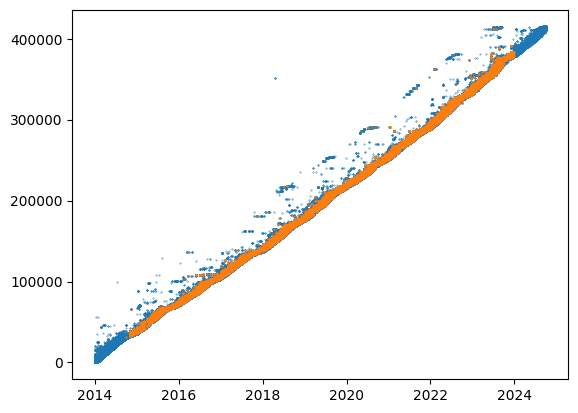

In [54]:
plt.scatter(storms_with_response_var.begin_datetime,storms_with_response_var.index, s=0.1)
plt.scatter(
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].begin_datetime,
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].index, s=0.1
)

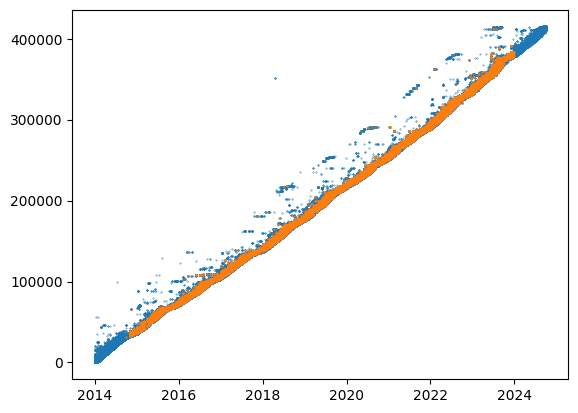

In [55]:
plt.scatter(storms_with_response_var.begin_datetime,storms_with_response_var.index, s=0.1)
plt.scatter(
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].begin_datetime,
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].index, s=0.1
)

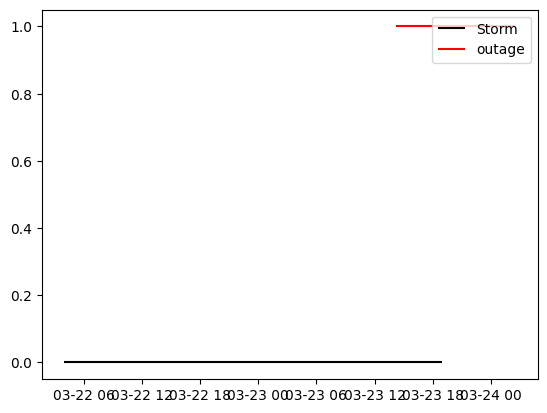

In [57]:
test = storms_caused_outages.sample(1)
test = test.reset_index().reset_index()
plt.hlines(test.level_0, test.begin_datetime, test.end_datetime, color='k', label='Storm')
plt.hlines(test.level_0 + 1, test.run_start_time_min, test.run_start_time_max, color='r', label='outage')
plt.legend()

## Response Var

In [58]:
storms_with_response_var.storm_caused_outage =  storms_with_response_var.storm_caused_outage.fillna(0)

In [59]:
storms_with_response_var.to_parquet('../data/interim/storm_outages_2014_2023.parquet')

In [ ]:
#plt.hist(np.log10(storms_with_response_var.storm_duration))
#plt.hist(np.log10(storms_with_response_var[storms_with_response_var.storm_caused_outage==1].storm_duration))

In [ ]:
#plt.hist(np.log10(storms_with_response_var.storm_duration))

In [ ]:
storms_with_response_var.storm_caused_outage.value_counts(normalize=True)

In [ ]:
storms_with_response_var.storm_caused_outage.value_counts()